In [1]:
# Reference: https://www.tensorflow.org/text/tutorials/classify_text_with_bert
import pandas as pd
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

import os
import shutil

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
from official.nlp import optimization  # to create AdamW optimizer
from keras.models import load_model

import matplotlib.pyplot as plt

tf.get_logger().setLevel('ERROR')

2023-07-23 12:09:19.514776: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# For saving result to tempoary file
import sys
import logging

nblog = open("nb.log", "a+")
sys.stdout.echo = nblog
sys.stderr.echo = nblog

get_ipython().log.handlers[0].stream = nblog
get_ipython().log.setLevel(logging.INFO)

%autosave 5

Autosaving every 5 seconds


In [3]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


2023-07-23 12:09:28.918587: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


In [4]:
# Get BERT model
bert_model_name = 'small_bert/bert_en_uncased_L-2_H-512_A-8' 

map_name_to_handle = {
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-768_A-12/1',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_base/2',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/talkheads_ggelu_bert_en_base/1'
}

map_model_to_preprocess = {
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_preprocess/3',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
}

tfhub_handle_encoder = map_name_to_handle[bert_model_name]
tfhub_handle_preprocess = map_model_to_preprocess[bert_model_name]

print(f'BERT model selected           : {tfhub_handle_encoder}')
print(f'Preprocess model auto-selected: {tfhub_handle_preprocess}')

BERT model selected           : https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-512_A-8/1
Preprocess model auto-selected: https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3


In [5]:
# Build the model
def build_classifier_model(tfhub_handle_encoder, tfhub_handle_preprocess, dropout = 0.1):
#     preprocessor = hub.load(tfhub_handle_preprocess)
#     text_inputs = [tf.keras.layers.Input(shape=(), dtype=tf.string)]
#     tokenize = hub.KerasLayer(preprocessor.tokenize)
#     tokenized_inputs = [tokenize(segment) for segment in text_inputs]
    
#     seq_length = 512  # Your choice here.
#     bert_pack_inputs = hub.KerasLayer(
#         preprocessor.bert_pack_inputs,
#         arguments=dict(seq_length=seq_length))  # Optional argument.
#     encoder_inputs = bert_pack_inputs(tokenized_inputs)
    
    
    text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
    preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
    encoder_inputs = preprocessing_layer(text_input)

    encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT_encoder')
    outputs = encoder(encoder_inputs)
    net = outputs['pooled_output']
    net = tf.keras.layers.Dropout(dropout)(net)
    net = tf.keras.layers.Dense(1, activation=None, name='classifier')(net)
    return tf.keras.Model(text_input, net)

In [6]:
# Compile the model
def compile_model(classifier_model, train_ds, lr = 3e-6, epochs = 5):
    # model fine tuning
    loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
    metrics = tf.metrics.BinaryAccuracy()

    steps_per_epoch = tf.data.experimental.cardinality(train_ds).numpy()
    num_train_steps = steps_per_epoch * epochs
    num_warmup_steps = int(0.1*num_train_steps)

    optimizer = optimization.create_optimizer(init_lr=lr,
                                              num_train_steps=num_train_steps,
                                              num_warmup_steps=num_warmup_steps,
                                              optimizer_type='adamw')

    classifier_model.compile(optimizer=optimizer,
                             loss=loss,
                             metrics=metrics)
    return classifier_model

In [7]:
# Prepare dataset
def prepare_data(dataset):
    # Load the dataset
    df = pd.read_csv(f'../dataset/{dataset}', encoding='utf-8').dropna()
    df.columns = ['label', 'text']
    
    # # Sample only 20% to test BERT training faster
    # df, df_discard = train_test_split(df, test_size=0.99, random_state=7)

    # Use sklearn to split the dataset into training, validating and testing
    train_df, val_df = train_test_split(df, test_size=0.3, random_state=7)
    val_df, test_df = train_test_split(val_df, test_size=0.33, random_state=7)

    # Create training dataset
    AUTOTUNE = tf.data.AUTOTUNE
    batch_size = 8

    train_ds = tf.data.Dataset.from_tensor_slices(
        (train_df['text'].values, train_df['label'].values)
    )
    train_ds = train_ds.batch(batch_size).cache().prefetch(buffer_size=AUTOTUNE)

    # Create validation dataset
    val_ds = tf.data.Dataset.from_tensor_slices(
        (val_df['text'].values, val_df['label'].values)
    )
    val_ds = val_ds.batch(batch_size).cache().prefetch(buffer_size=AUTOTUNE)

    # Create testing dataset
    test_ds = tf.data.Dataset.from_tensor_slices(
        (test_df['text'].values, test_df['label'].values)
    )
    test_ds = test_ds.batch(batch_size).cache().prefetch(buffer_size=AUTOTUNE)
    
    return train_ds, val_ds, test_ds


In [8]:
# Show result
def evaluate_model(classifier_model, test_ds):
    # Evaluate performance
    loss, accuracy = classifier_model.evaluate(test_ds)

    print(f'Loss: {loss}')
    print(f'Accuracy: {accuracy}')
    
def show_history(history, shouldSave = False, modelName = ''):
    history_dict = history.history
    print(history_dict.keys())

    acc = history_dict['binary_accuracy']
    val_acc = history_dict['val_binary_accuracy']
    loss = history_dict['loss']
    val_loss = history_dict['val_loss']

    epochs = range(1, len(acc) + 1)
    fig = plt.figure(figsize=(10, 6))
    fig.tight_layout()

    plt.subplot(2, 1, 1)
    # r is for "solid red line"
    plt.plot(epochs, loss, 'r', label='Training loss')
    # b is for "solid blue line"
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    # plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(2, 1, 2)
    plt.plot(epochs, acc, 'r', label='Training acc')
    plt.plot(epochs, val_acc, 'b', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend(loc='lower right')
    
    fig.savefig('saved_model/' + modelName + '.png')

In [ ]:
# Best learning rate by experiment is 3e-5

models = [
    # 'small_bert/bert_en_uncased_L-2_H-128_A-2',
    # 'small_bert/bert_en_uncased_L-4_H-256_A-4',
    # 'small_bert/bert_en_uncased_L-4_H-512_A-8',
    'small_bert/bert_en_uncased_L-8_H-512_A-8',
    # 'small_bert/bert_en_uncased_L-10_H-128_A-2',
    # 'small_bert/bert_en_uncased_L-12_H-256_A-4',
    # 'small_bert/bert_en_uncased_L-12_H-512_A-8'
]


for modelName in models:
    print("Training for model: ", modelName)
    tfhub_handle_encoder = map_name_to_handle[modelName]
    tfhub_handle_preprocess = map_model_to_preprocess[modelName]
    model = build_classifier_model(tfhub_handle_encoder, tfhub_handle_preprocess, 0.2)
    train_ds, val_ds, test_ds = prepare_data("best_dataset.csv")
    classifier_model = compile_model(model, train_ds, 3e-5)
    history = classifier_model.fit(x=train_ds,
                               validation_data=val_ds,
                               epochs=7)
    
    print("Performance for model: ", modelName)
    evaluate_model(classifier_model, test_ds)
    show_history(history, True, modelName)
    
    classifier_model.save('saved_model/' + modelName)

Training for model:  small_bert/bert_en_uncased_L-8_H-512_A-8
Epoch 1/7
2886/2886 [==============================] - 226s 74ms/step - loss: 0.2687 - binary_accuracy: 0.9016 - val_loss: 0.2008 - val_binary_accuracy: 0.9425
Epoch 2/7
2886/2886 [==============================] - 218s 76ms/step - loss: 0.1681 - binary_accuracy: 0.9525 - val_loss: 0.2067 - val_binary_accuracy: 0.9501
Epoch 3/7
2886/2886 [==============================] - 233s 81ms/step - loss: 0.1386 - binary_accuracy: 0.9624 - val_loss: 0.2110 - val_binary_accuracy: 0.9513
Epoch 4/7
2886/2886 [==============================] - 215s 74ms/step - loss: 0.1146 - binary_accuracy: 0.9709 - val_loss: 0.1918 - val_binary_accuracy: 0.9578
Epoch 5/7
2886/2886 [==============================] - 233s 81ms/step - loss: 0.0960 - binary_accuracy: 0.9750 - val_loss: 0.2029 - val_binary_accuracy: 0.9582
Epoch 6/7
1755/2886 [=================>............] - ETA: 1:14 - loss: 0.0895 - binary_accuracy: 0.9773

In [80]:
# Save the model
classifier_model.save('saved_model/smokeTestBertSmsClassifier', include_optimizer=False)

In [75]:
classifier_model.summary()

Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text (InputLayer)              [(None,)]            0           []                               
                                                                                                  
 preprocessing (KerasLayer)     {'input_mask': (Non  0           ['text[0][0]']                   
                                e, 128),                                                          
                                 'input_type_ids':                                                
                                (None, 128),                                                      
                                 'input_word_ids':                                                
                                (None, 128)}                                                

In [14]:
# Plot confusion matrix and graph
def plot_confusion_matrix(y, y_pred, type, modelName, target_names = ['Ham', 'Spam']):
    print('Confusion matrix - ' + type)
    confusion_report = classification_report(y, y_pred, target_names=target_names, digits=4)
    print(confusion_report)
    with open(f"model_result/{modelName}_{type}.txt", 'x') as f:
        f.write(confusion_report)
    
    cm = confusion_matrix(y, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=target_names, yticklabels=target_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix - ' + type)
    plt.savefig(f"model_result/{modelName}_{type}.jpg", format='jpeg')
    plt.show()
    

In [11]:
# Evaluate performance in term of confusing matrix
# Check confusion matrix given dataset and model. Reference: https://colab.research.google.com/drive/1kEg0SnYNtw_IJwu_kl5y3qRVs-BKBmNO#scrollTo=_r4smPUZymS5
def evaluateDatasetConfusionMatrix(dataset, model, modelName):
    train_ds, val_ds, test_ds = prepare_data(dataset)

    y_val_pred = tf.math.round(tf.nn.sigmoid(model.predict(val_ds)))
    y_test_pred = tf.math.round(tf.nn.sigmoid(model.predict(test_ds)))

    y_val = tf.Variable([], dtype=tf.int64)
    for features, label in val_ds.take(-1):
        y_val = tf.concat([y_val, label], 0)

    y_test = tf.Variable([], dtype=tf.int64)
    for features, label in test_ds.take(-1):
        y_test = tf.concat([y_test, label], 0)
    

    plot_confusion_matrix(y_val, y_val_pred, 'Validation', modelName)
    plot_confusion_matrix(y_test, y_test_pred, 'Testing', modelName)

Try loading model saved_model/small_bert_backup/bert_en_uncased_L-2_H-128_A-2
loaded!
409/409 [==============================] - 8s 18ms/step
Confusion matrix - Validation
              precision    recall  f1-score   support

         Ham     0.8287    0.9710    0.8942      3100
        Spam     0.9700    0.8237    0.8909      3528

    accuracy                         0.8926      6628
   macro avg     0.8994    0.8973    0.8926      6628
weighted avg     0.9039    0.8926    0.8924      6628



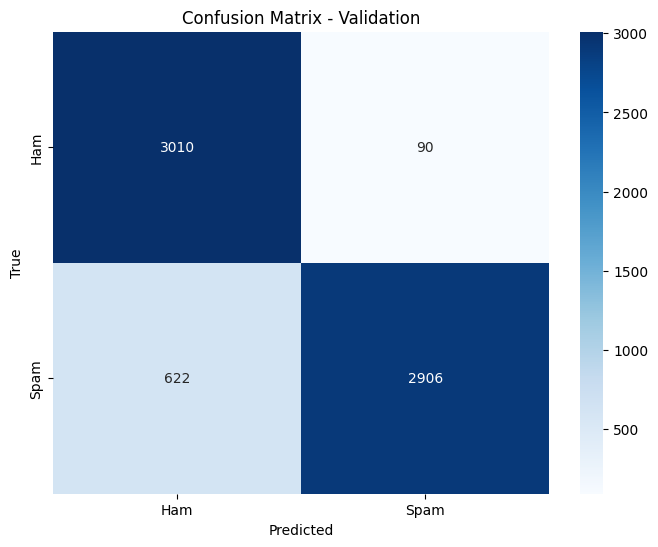

Confusion matrix - Testing
              precision    recall  f1-score   support

         Ham     0.8285    0.9662    0.8921      1510
        Spam     0.9661    0.8279    0.8917      1755

    accuracy                         0.8919      3265
   macro avg     0.8973    0.8971    0.8919      3265
weighted avg     0.9025    0.8919    0.8919      3265



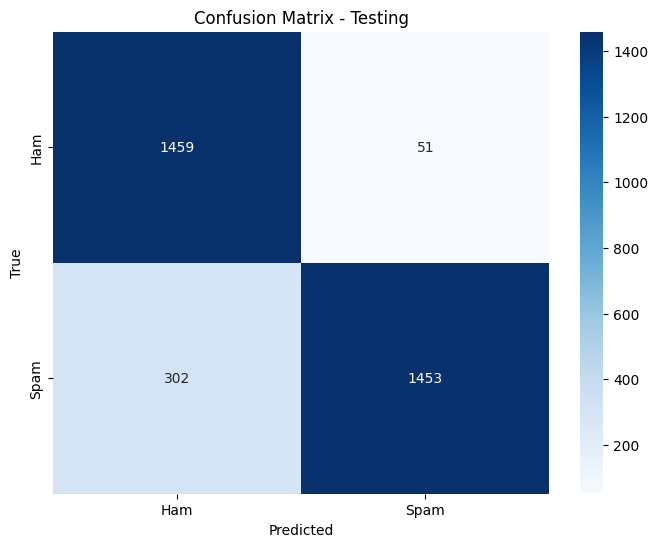

Try loading model saved_model/small_bert_backup/bert_en_uncased_L-4_H-256_A-4
loaded!
409/409 [==============================] - 8s 20ms/step
Confusion matrix - Validation
              precision    recall  f1-score   support

         Ham     0.9062    0.9726    0.9382      3100
        Spam     0.9743    0.9116    0.9419      3528

    accuracy                         0.9401      6628
   macro avg     0.9402    0.9421    0.9400      6628
weighted avg     0.9424    0.9401    0.9402      6628



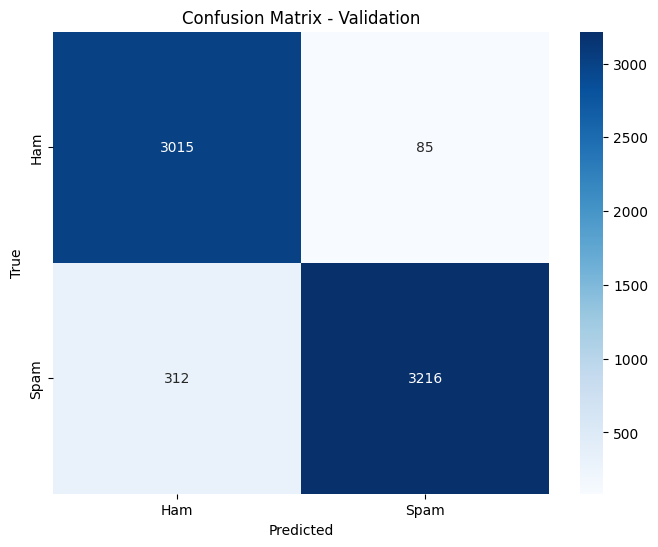

Confusion matrix - Testing
              precision    recall  f1-score   support

         Ham     0.9035    0.9801    0.9403      1510
        Spam     0.9816    0.9100    0.9444      1755

    accuracy                         0.9424      3265
   macro avg     0.9426    0.9451    0.9423      3265
weighted avg     0.9455    0.9424    0.9425      3265



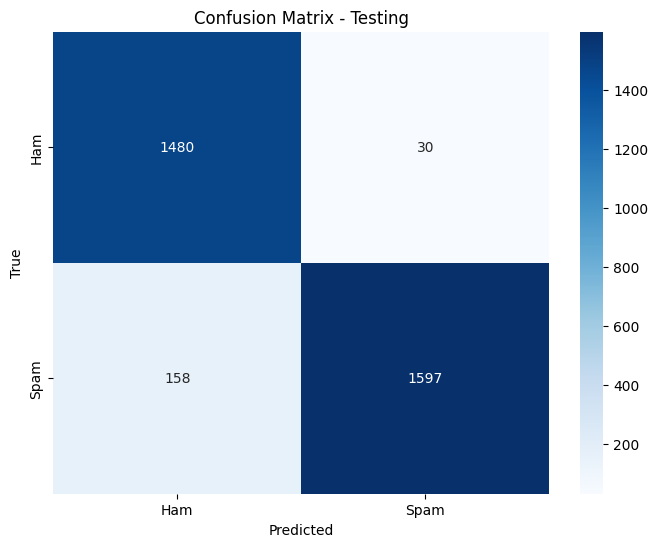

Try loading model saved_model/small_bert_backup/bert_en_uncased_L-4_H-512_A-8
loaded!
409/409 [==============================] - 8s 21ms/step
Confusion matrix - Validation
              precision    recall  f1-score   support

         Ham     0.9174    0.9742    0.9449      3100
        Spam     0.9760    0.9229    0.9487      3528

    accuracy                         0.9469      6628
   macro avg     0.9467    0.9485    0.9468      6628
weighted avg     0.9486    0.9469    0.9469      6628



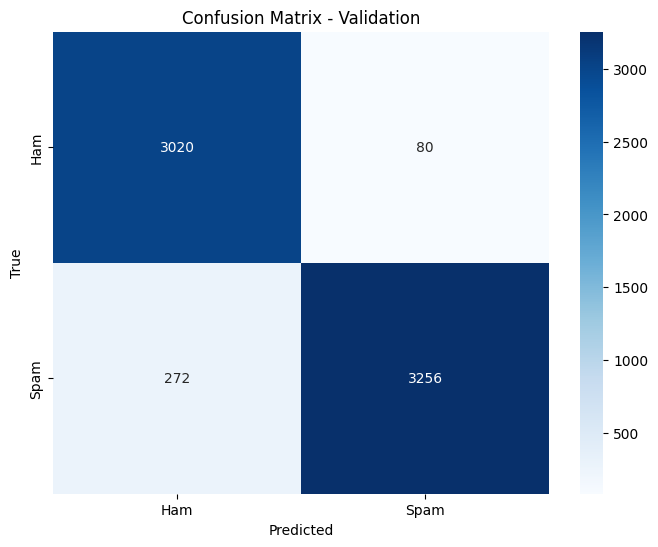

Confusion matrix - Testing
              precision    recall  f1-score   support

         Ham     0.9153    0.9801    0.9466      1510
        Spam     0.9818    0.9219    0.9509      1755

    accuracy                         0.9489      3265
   macro avg     0.9485    0.9510    0.9488      3265
weighted avg     0.9510    0.9489    0.9489      3265



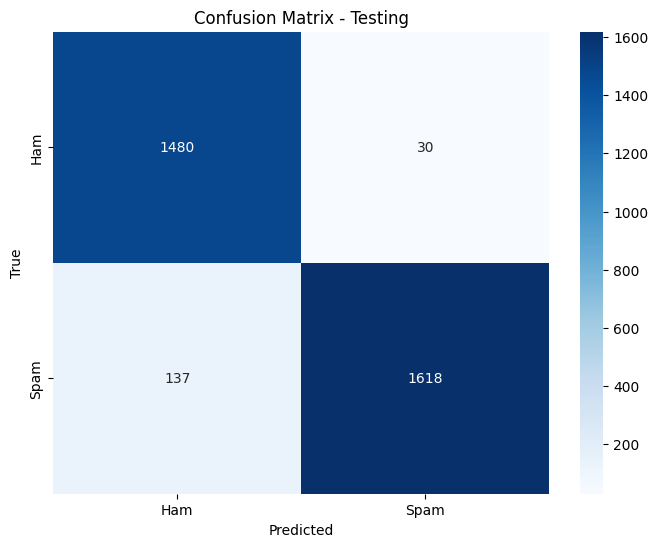

Try loading model saved_model/small_bert_backup/bert_en_uncased_L-8_H-512_A-8
loaded!
409/409 [==============================] - 10s 25ms/step
Confusion matrix - Validation
              precision    recall  f1-score   support

         Ham     0.9206    0.9758    0.9474      3100
        Spam     0.9776    0.9260    0.9511      3528

    accuracy                         0.9493      6628
   macro avg     0.9491    0.9509    0.9492      6628
weighted avg     0.9509    0.9493    0.9494      6628



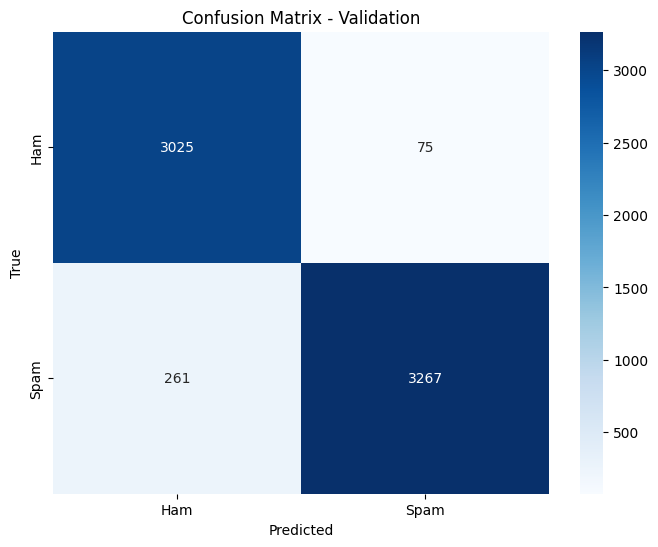

Confusion matrix - Testing
              precision    recall  f1-score   support

         Ham     0.9223    0.9828    0.9516      1510
        Spam     0.9843    0.9288    0.9557      1755

    accuracy                         0.9538      3265
   macro avg     0.9533    0.9558    0.9537      3265
weighted avg     0.9556    0.9538    0.9538      3265



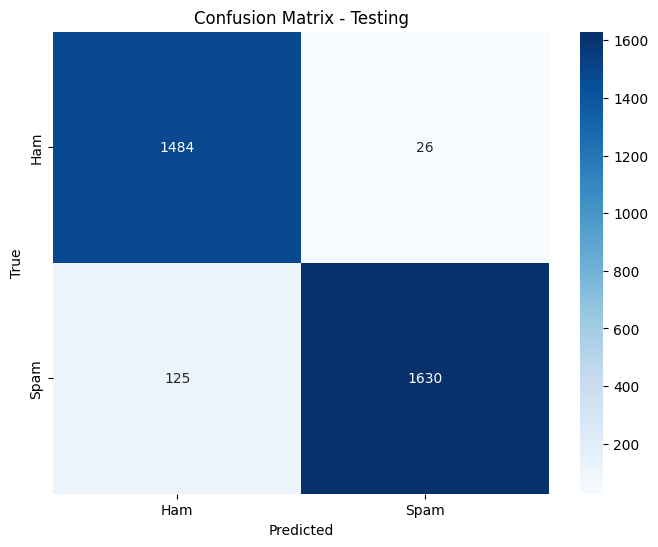

Try loading model saved_model/small_bert_backup/bert_en_uncased_L-10_H-128_A-2
loaded!
409/409 [==============================] - 11s 26ms/step
Confusion matrix - Validation
              precision    recall  f1-score   support

         Ham     0.8843    0.9694    0.9249      3100
        Spam     0.9706    0.8886    0.9278      3528

    accuracy                         0.9264      6628
   macro avg     0.9275    0.9290    0.9263      6628
weighted avg     0.9303    0.9264    0.9264      6628



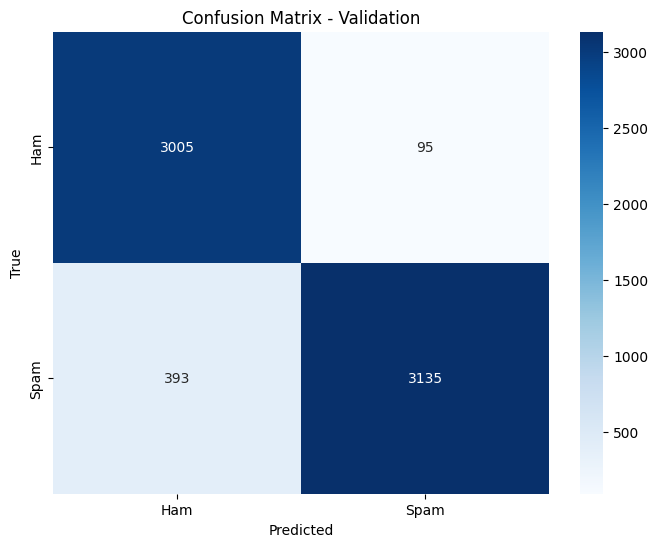

Confusion matrix - Testing
              precision    recall  f1-score   support

         Ham     0.8807    0.9775    0.9266      1510
        Spam     0.9786    0.8860    0.9300      1755

    accuracy                         0.9283      3265
   macro avg     0.9296    0.9318    0.9283      3265
weighted avg     0.9333    0.9283    0.9284      3265



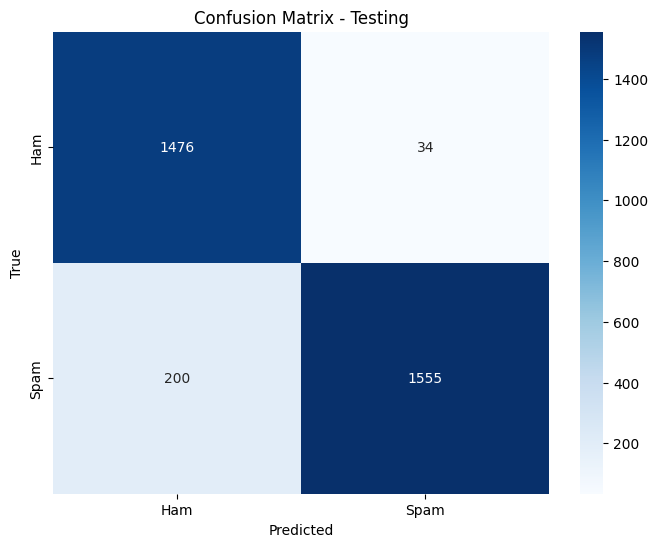

Try loading model saved_model/small_bert_backup/bert_en_uncased_L-12_H-256_A-4
loaded!
409/409 [==============================] - 11s 28ms/step
Confusion matrix - Validation
              precision    recall  f1-score   support

         Ham     0.8988    0.9794    0.9373      3100
        Spam     0.9803    0.9031    0.9401      3528

    accuracy                         0.9387      6628
   macro avg     0.9395    0.9412    0.9387      6628
weighted avg     0.9422    0.9387    0.9388      6628



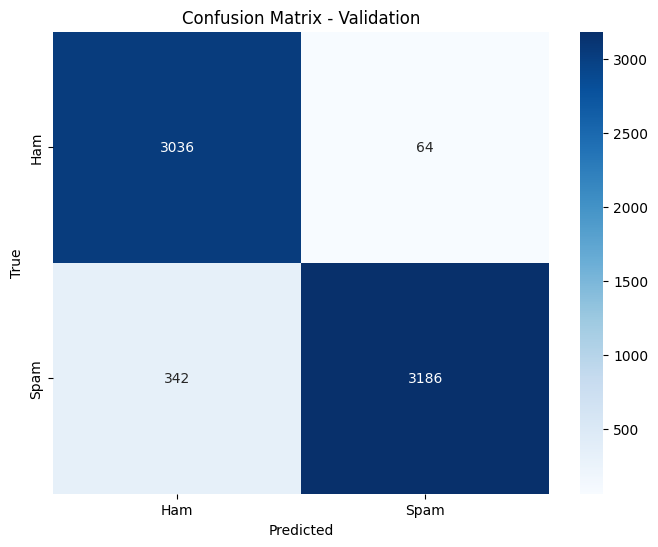

Confusion matrix - Testing
              precision    recall  f1-score   support

         Ham     0.8968    0.9841    0.9384      1510
        Spam     0.9851    0.9026    0.9420      1755

    accuracy                         0.9403      3265
   macro avg     0.9409    0.9433    0.9402      3265
weighted avg     0.9442    0.9403    0.9404      3265



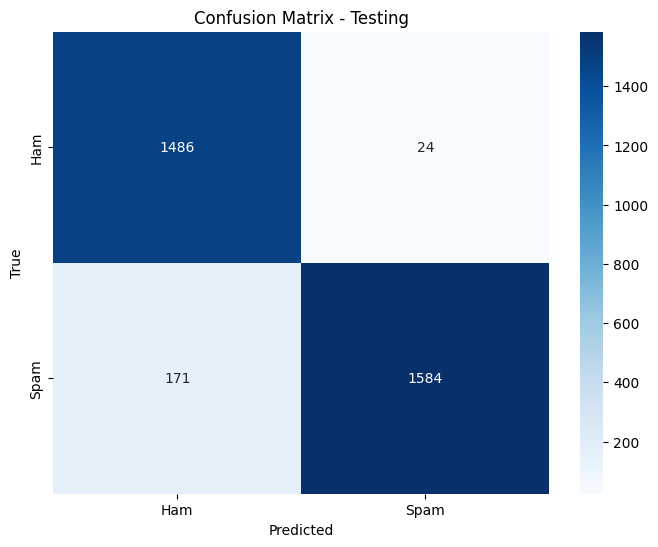

Try loading model saved_model/small_bert_backup/with_lr_3e-5_dropout_0.05/bert_en_uncased_L-2_H-128_A-2
loaded!
409/409 [==============================] - 7s 18ms/step
Confusion matrix - Validation
              precision    recall  f1-score   support

         Ham     0.9179    0.9661    0.9414      3100
        Spam     0.9688    0.9240    0.9459      3528

    accuracy                         0.9437      6628
   macro avg     0.9433    0.9451    0.9436      6628
weighted avg     0.9450    0.9437    0.9438      6628



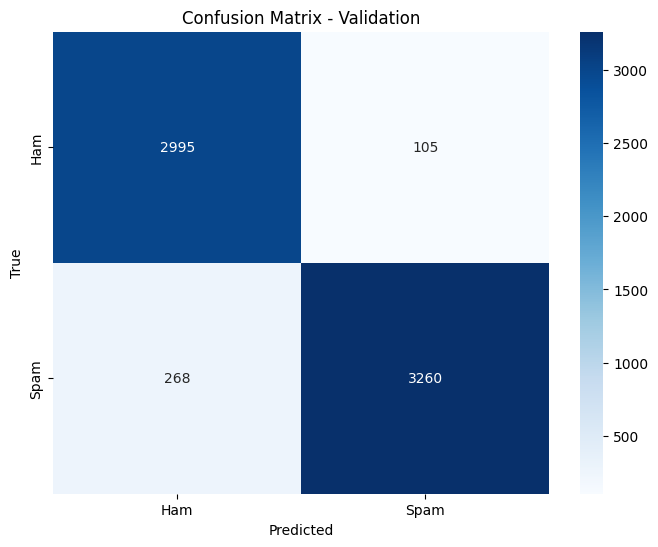

Confusion matrix - Testing
              precision    recall  f1-score   support

         Ham     0.9139    0.9702    0.9412      1510
        Spam     0.9729    0.9214    0.9464      1755

    accuracy                         0.9440      3265
   macro avg     0.9434    0.9458    0.9438      3265
weighted avg     0.9456    0.9440    0.9440      3265



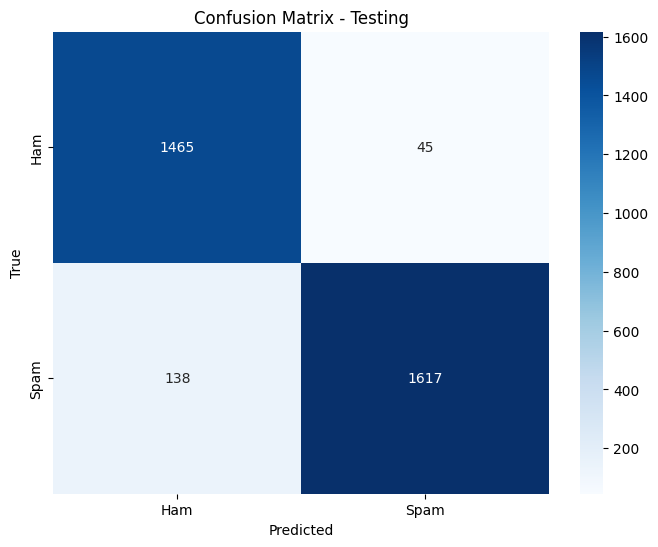

Try loading model saved_model/small_bert_backup/with_lr_3e-5_dropout_0.05/bert_en_uncased_L-4_H-256_A-4
loaded!
409/409 [==============================] - 9s 21ms/step
Confusion matrix - Validation
              precision    recall  f1-score   support

         Ham     0.9338    0.9694    0.9513      3100
        Spam     0.9721    0.9396    0.9556      3528

    accuracy                         0.9535      6628
   macro avg     0.9530    0.9545    0.9534      6628
weighted avg     0.9542    0.9535    0.9536      6628



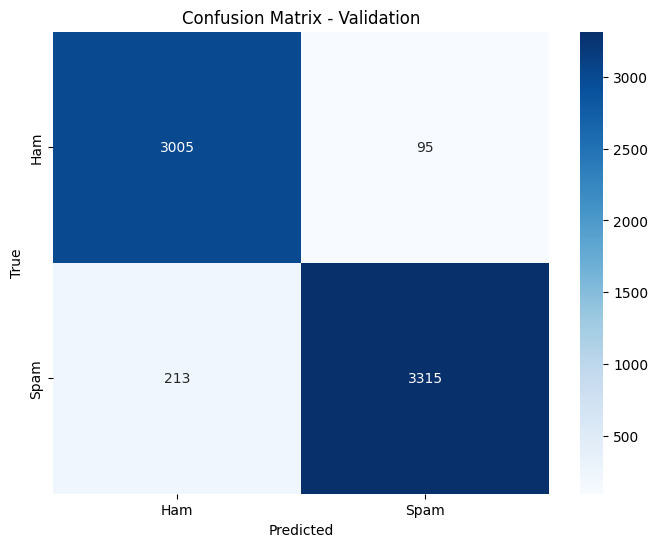

Confusion matrix - Testing
              precision    recall  f1-score   support

         Ham     0.9378    0.9689    0.9531      1510
        Spam     0.9724    0.9447    0.9584      1755

    accuracy                         0.9559      3265
   macro avg     0.9551    0.9568    0.9557      3265
weighted avg     0.9564    0.9559    0.9559      3265



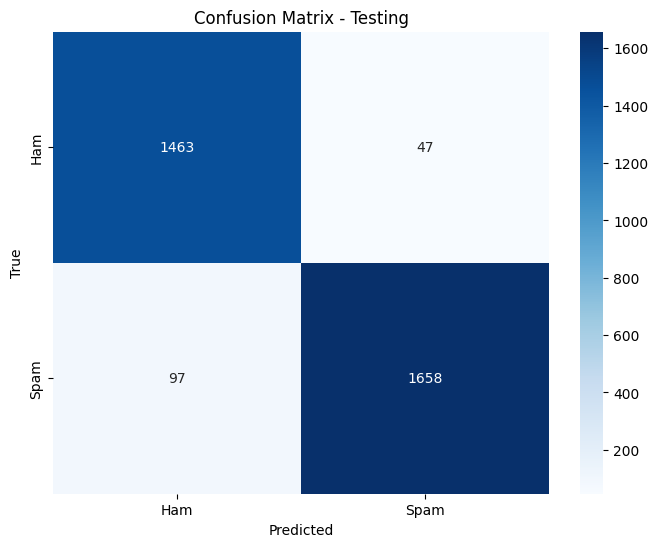

Try loading model saved_model/small_bert_backup/with_lr_3e-5_dropout_0.05/bert_en_uncased_L-4_H-512_A-8
loaded!
409/409 [==============================] - 8s 20ms/step
Confusion matrix - Validation
              precision    recall  f1-score   support

         Ham     0.9402    0.9684    0.9541      3100
        Spam     0.9715    0.9459    0.9585      3528

    accuracy                         0.9564      6628
   macro avg     0.9558    0.9571    0.9563      6628
weighted avg     0.9568    0.9564    0.9564      6628



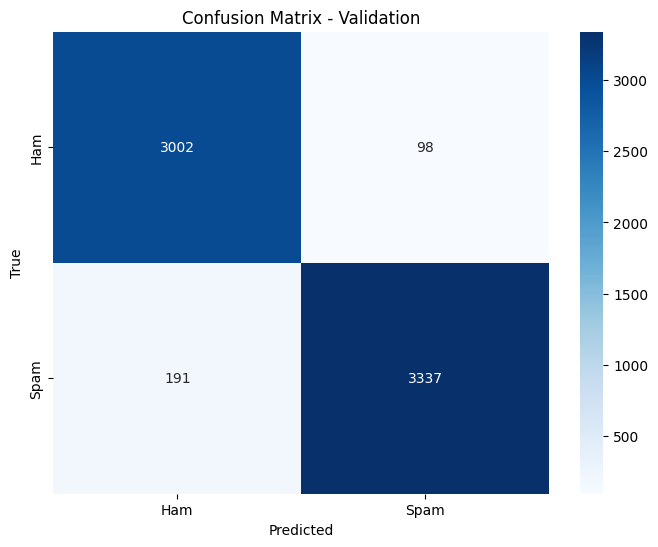

Confusion matrix - Testing
              precision    recall  f1-score   support

         Ham     0.9399    0.9735    0.9564      1510
        Spam     0.9765    0.9464    0.9612      1755

    accuracy                         0.9590      3265
   macro avg     0.9582    0.9600    0.9588      3265
weighted avg     0.9596    0.9590    0.9590      3265



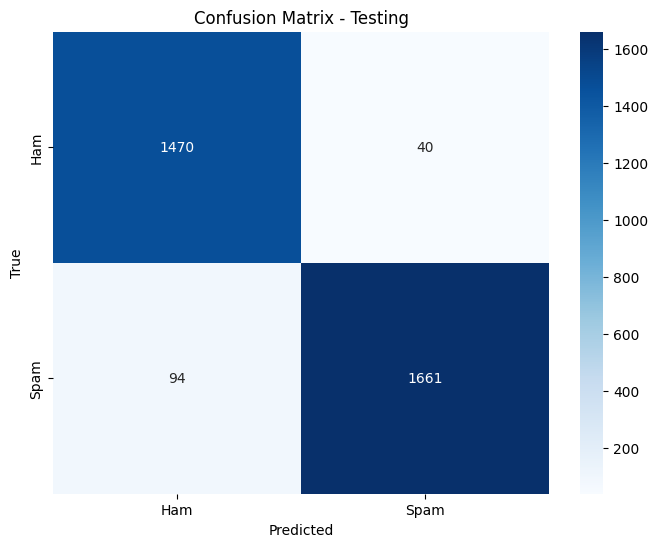

Try loading model saved_model/small_bert_backup/with_lr_3e-5_dropout_0.05/bert_en_uncased_L-8_H-512_A-8
loaded!
409/409 [==============================] - 10s 25ms/step
Confusion matrix - Validation
              precision    recall  f1-score   support

         Ham     0.9406    0.9661    0.9532      3100
        Spam     0.9695    0.9464    0.9578      3528

    accuracy                         0.9556      6628
   macro avg     0.9551    0.9563    0.9555      6628
weighted avg     0.9560    0.9556    0.9557      6628



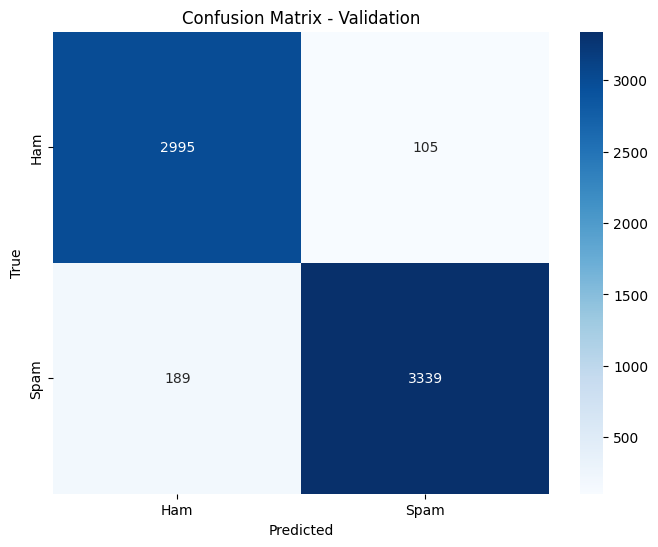

Confusion matrix - Testing
              precision    recall  f1-score   support

         Ham     0.9471    0.9715    0.9591      1510
        Spam     0.9749    0.9533    0.9640      1755

    accuracy                         0.9617      3265
   macro avg     0.9610    0.9624    0.9616      3265
weighted avg     0.9620    0.9617    0.9617      3265



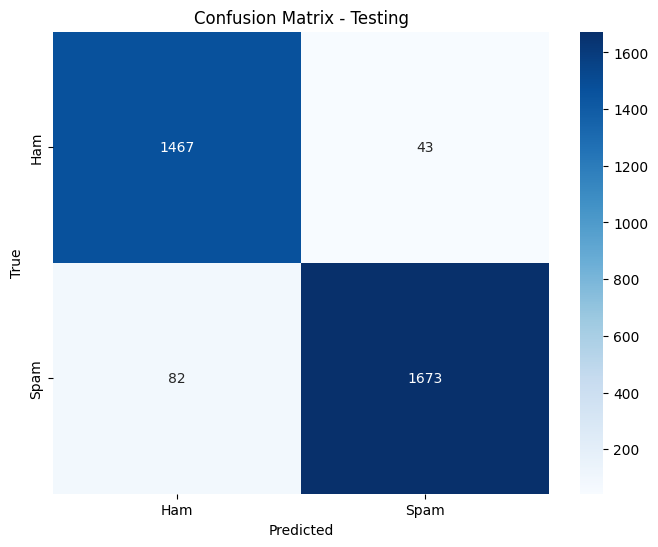

Try loading model saved_model/small_bert/bert_en_uncased_L-8_H-512_A-8
loaded!
409/409 [==============================] - 10s 25ms/step
Confusion matrix - Validation
              precision    recall  f1-score   support

         Ham     0.9451    0.9668    0.9558      3100
        Spam     0.9702    0.9507    0.9603      3528

    accuracy                         0.9582      6628
   macro avg     0.9577    0.9587    0.9581      6628
weighted avg     0.9585    0.9582    0.9582      6628



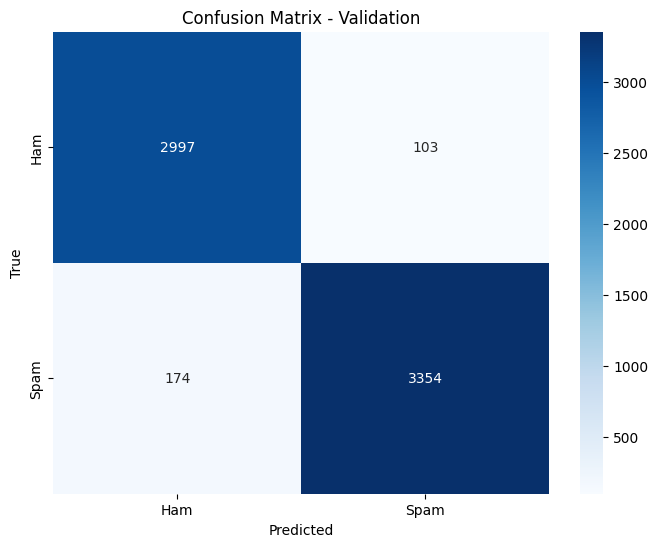

Confusion matrix - Testing
              precision    recall  f1-score   support

         Ham     0.9477    0.9715    0.9595      1510
        Spam     0.9750    0.9538    0.9643      1755

    accuracy                         0.9620      3265
   macro avg     0.9613    0.9627    0.9619      3265
weighted avg     0.9623    0.9620    0.9620      3265



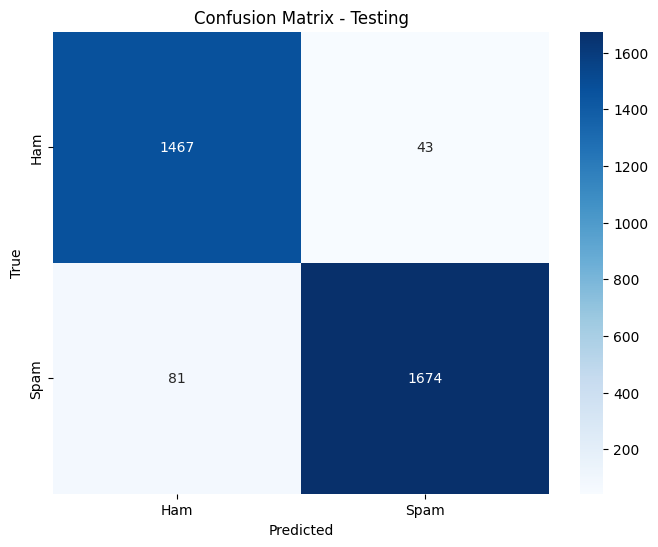

In [15]:
# evaluateDatasetConfusionMatrix('best_dataset.csv', loaded_model, 'small_bert/bert_en_uncased_L-8_H-512_A-8')

# Check all trained model confusion matrix for comparison
saved_models = [
    'saved_model/small_bert_backup/bert_en_uncased_L-2_H-128_A-2',
    'saved_model/small_bert_backup/bert_en_uncased_L-4_H-256_A-4',
    'saved_model/small_bert_backup/bert_en_uncased_L-4_H-512_A-8',
    'saved_model/small_bert_backup/bert_en_uncased_L-8_H-512_A-8',
    'saved_model/small_bert_backup/bert_en_uncased_L-10_H-128_A-2',
    'saved_model/small_bert_backup/bert_en_uncased_L-12_H-256_A-4',
    'saved_model/small_bert_backup/with_lr_3e-5_dropout_0.05/bert_en_uncased_L-2_H-128_A-2',
    'saved_model/small_bert_backup/with_lr_3e-5_dropout_0.05/bert_en_uncased_L-4_H-256_A-4',
    'saved_model/small_bert_backup/with_lr_3e-5_dropout_0.05/bert_en_uncased_L-4_H-512_A-8',
    'saved_model/small_bert_backup/with_lr_3e-5_dropout_0.05/bert_en_uncased_L-8_H-512_A-8',
    'saved_model/small_bert/bert_en_uncased_L-8_H-512_A-8',
]

for model in saved_models:
    print("Try loading model " + model)
    loaded_model = load_model(model, compile=False)
    print("loaded!")
    evaluateDatasetConfusionMatrix('best_dataset.csv', loaded_model, model)


In [18]:
test_data_spam = [
    "咪咕 帶 您 體驗 正版 的 音樂 世界 新 歌 搶鮮 試聽 潮流 鈴音 隨心換 百場 歌友會 演唱會 門票 免費 搶 number 月 日前 登錄 還 能 免費 領取 number m 流量 下載 點擊 link",
    "中移 通訊 手機 免費送 平板 免費 拿 只 需 number 元 價值 number 元 的 g 智慧型手機 number 元 的 平板 電腦 number 元 話費 生活 廣場 斜對面 金源 豐 手機 大 賣場",
    "和 娛樂 雙周刊 港 囧 來 襲 攜 薇 包 高空 冒險 情 在 囧 途 爆笑 歸來 詳情 點擊 link ctpn 手慢 無送 又 逢 開學 季 噹噹 買書 享 優惠 啦 每周 一至 周五 下午 三點 當 當 圖書 音像 禮券 等 你 來 搶 點擊 link 如 不 需 接收 本刊 回復 hylzt 退訂",
    "yes 月 日 添益 寶 用戶 狂歡 日 就是 它 了 當天 您 在 指定 商戶 門店 消費 可享 折 優惠 最高 省 元 哦 添 用戶 專享 超高 收益 理財產品 等 著 您 這麼 賺 當然 得 加入 添益 寶 登錄 翼 支付 客戶端 詳情 一網打盡 翼 支付",
    "尊敬 的 客戶 根據 您 的 流量 使用 狀況 推薦 您 回復 sjll number 開通 number 元 流量 套餐 現在 辦理 年內 每月 再 送 您 number m 省內 流量 加量 不 加價 流量 大 優惠 詳詢 number 中國移動",
]

test_data_ham = [
    "店鋪 導航 設置 失敗 店鋪 導航 已經 修改 了 天 了 在 微信 界面 還是 沒有 修改",
    "重要 買家 無法 支付 和 地區 不 支持 最近 一直 會 出現 有 買家 選擇 收貨 地址 顯示 不 支持 的 情況 發生 但是 其 所在區域 是 支持 的 比如 河北 有 兩位 用戶 均 不 支持 該 地區 配送 但 運費 模板 上 是 支持 的 另外 還有 相同 地區 的 用戶 有人 可 下單 有人 不可 下單 甚至 連 支付 方式 都 看不到 而 如上 情況 都 是 在 關注 和 註冊 以後 發生 的",
    "認證 企業 信息 被盜 用 怎麼辦 企業 信息 無法 認證 信息 已 被 認證 盜用 請 有贊 平臺 給予 人工 認證 並把 盜用 信息 帳號 給予 刪除",
    "註冊 後 原來 微信 開發 的 菜單 都 失效 了 怎麼辦 你好 註冊 了 有贊 後 原來 自己 找人 開發 的 菜單 都 失效 了 請問 怎麼辦",
    "顧客 接待 客戶端 用不了 客戶 接待 客戶端 更新 之後 沒什麼 上不了 只能 上 網頁版 的"
]

print("SPAM")
for data in test_data_spam:
    result = loaded_model.predict([data])
    print(result)
    
print("\nHAM")
for data in test_data_ham:
    result = loaded_model.predict([data])
    print(result)

SPAM
1/1 [==============================] - 1s 774ms/step
[[10.051525]]
1/1 [==============================] - 0s 63ms/step
[[10.030289]]
1/1 [==============================] - 0s 62ms/step
[[10.105345]]
1/1 [==============================] - 0s 68ms/step
[[9.679992]]
1/1 [==============================] - 0s 65ms/step
[[9.986523]]

HAM
1/1 [==============================] - 0s 66ms/step
[[-7.529234]]
1/1 [==============================] - 0s 73ms/step
[[-7.6559753]]
1/1 [==============================] - 0s 75ms/step
[[-7.6358843]]
1/1 [==============================] - 0s 73ms/step
[[-7.7409554]]
1/1 [==============================] - 0s 72ms/step
[[-7.6663275]]


In [37]:
print(round(0.9))
print(round(0.51))
print(round(0.49999))
print(round(0.01))

1
1
0
0


dict_keys([])


KeyError: 'binary_accuracy'